# Rastreamento de objetos e machine learning

Rastreamento de cores, objetos e aplicação de técnicas de machine learning pré-treinadas e desenvolvimento de algoritmos próprios.

** Importante ressaltar que precisamos do OpenCV >= 3.4.2. Pode ser instalado pelo comando**

```conda install -c conda-forge opencv```

In [1]:
import cv2
print(cv2.__version__)

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

plt.style.use('seaborn')

3.4.3


Verificando versão instalada do OpenCV

## Rastreamento de objetos

## Filtro por cor

Calibração de cor. 

É importante ressaltar que o Gimp usa o HSV com valores H de 0 a 180 S e V de 0 a 360. O OpenCV utiliza H de 0 a 100 e S e V de 0 a 255.

In [14]:
blue = np.uint8([[[255, 0, 0]]])
hsv = cv2.cvtColor(blue,cv2.COLOR_BGR2HSV)
print(hsv)

[[[120 255 255]]]


Utilizando uma imagem estática.m

In [ ]:
# Definindo limiares de cor, adotando H-10, 100, 100 para limite inferior e H+10, 255, 255 para limite superior
lower_blue = np.array([100,100,100])
upper_blue = np.array([130,255,255])

imagem = cv2.imread("imagens/caneta.jpg")
imagem = cv2.resize(imagem, (0,0), fx=0.5, fy=0.5) 

#Convertendo para HSV
hsv_img = cv2.cvtColor(imagem, cv2.COLOR_BGR2HSV)

# Criação de máscara de cores dentro do limtie
mask = cv2.inRange(hsv_img, lower_blue, upper_blue)

# Operação AND entre a máscara e a imagem original
res = cv2.bitwise_and(imagem, imagem, mask=mask)

cv2.imshow('Imagem original', imagem)  
cv2.imshow('Mascara', mask)
cv2.imshow('Filtro de cor azul', res)

cv2.waitKey()
cv2.destroyAllWindows()

Utilizando captura contínua de uma webcam.

In [ ]:
cap = cv2.VideoCapture(0)

# Definindo limiares de cor, adotando H-10, 100, 100 para limite inferior e H+10, 255, 255 para limite superior
lower_blue = np.array([100,100,100])
upper_blue = np.array([130,255,255])

while True:
    
    ret, frame = cap.read()
    
    if ret:
        # Os filtros foram feitos com HSV, logo precisamos converter neste spaço de cores.
        hsv_img = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

        # Criação de máscara de cores dentro do limtie
        mask = cv2.inRange(hsv_img, lower_blue, upper_blue)

        # Operação AND entre a máscara e a imagem original
        res = cv2.bitwise_and(frame, frame, mask=mask)

        cv2.imshow('Imagem original', frame)  
        cv2.imshow('Mascara', mask)
        cv2.imshow('Filtro de cor azul', res)
        
    #Tecla Enter interrompe o loop
    if cv2.waitKey(1) == 13:
        break
        
cap.release()
cv2.destroyAllWindows()

Aplicando ROI.

In [ ]:
cap = cv2.VideoCapture(0)

# Definindo limiares de cor, adotando H-10, 100, 100 para limite inferior e H+10, 255, 255 para limite superior
lower_blue = np.array([100,100,100])
upper_blue = np.array([130,255,255])

upper_left = (50, 50)
bottom_right = (300, 300)

while True:
    
    ret, frame = cap.read()
    
    if ret:
        
        #Rectangle marker
        r = cv2.rectangle(frame, upper_left, bottom_right, (100, 50, 200), 5)
        rect_img = frame[upper_left[1] : bottom_right[1], upper_left[0] : bottom_right[0]]
        
        hsv_img = cv2.cvtColor(rect_img, cv2.COLOR_BGR2HSV)
        mask = cv2.inRange(hsv_img, lower_blue, upper_blue)
        res = cv2.bitwise_and(rect_img, rect_img, mask=mask)
        
        frame[upper_left[1] : bottom_right[1], upper_left[0] : bottom_right[0]] = res

        cv2.imshow('Imagem original', frame)  
        
    #Tecla Enter interrompe o loop
    if cv2.waitKey(1) == 13:
        break
        
cap.release()
cv2.destroyAllWindows()

### Rastreamento de objetos baseado em cor

Aplicando um ROI diretamente na imagem.

In [17]:
import time

#Obtendo o primeiro frame para posicionar o retângulo inicial

cap = cv2.VideoCapture("videos/soccer-ita.avi")
play = True

while True:
    ret, frame = cap.read()
    if ret:
        cv2.imshow("Extracao ROI", frame)
        cv2.imwrite("roi_sample.png", frame)
        break
            
cv2.destroyAllWindows()
cap.release()  

In [27]:
#Escolha do ROI da imagem, neste exemplo vamos focar no juiz de vermelho

fromCenter = False
frame = cv2.imread("roi_sample.png")
r = cv2.selectROI("Image", frame, fromCenter)
roi = frame[r[1]:(r[1]+r[3]), r[0]:(r[0]+r[2])]
track_window = r[0], r[1], r[2], r[3]
cv2.imwrite("roi_sample_defined.png", roi)
cv2.imshow("Extracao ROI", roi)
cv2.waitKey(1)
cv2.destroyAllWindows()

In [34]:
track_window = r[0], r[1], r[2], r[3]

# Conversão para o espaço HSV
hsv_roi =  cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)

# Cálculo do histograma
roi_hist = cv2.calcHist([hsv_roi], [0], None, [180], [0,180])

# Normalizar os valors para o range 0, 255
cv2.normalize(roi_hist, roi_hist, 0, 255, cv2.NORM_MINMAX)

# Critério de término, encerrará o cálculo do centroid após 10 interações
# ou se o centróide mover, pelo menos 1 pixel
term_crit = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 20, 1)

cap = cv2.VideoCapture("videos/soccer-ita.avi")

while True:
    ret, frame = cap.read()
    if ret:
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        
        # Cálculo do histograma da projeção da imagem em região adjacente
        dst = cv2.calcBackProject([hsv],[0],roi_hist,[0,180],1)

        # Aplicação da técnica Mean Shift na nova região
        ret, track_window = cv2.meanShift(dst, track_window, term_crit)

        # Incluir retângulo
        x, y, w, h = track_window
        img2 = cv2.rectangle(frame, (x,y), (x+w, y+h), 255, 2)    
        cv2.imshow('Meansift Tracking', img2)
        
        if cv2.waitKey(1) == 13: #13 is the Enter Key
            break
        time.sleep(0.01)
    else:
        break

cv2.destroyAllWindows()
cv2.waitKey(1)
cap.release()

Utilizando Meanshift

In [15]:
cap = cv2.VideoCapture(0)

# Configuração do retângulo para capturar as características do objeto a ser rastreado
r, h, c, w = 240, 100, 400, 160 
track_window = (c, r, w, h)

while True:
    ret, frame = cap.read()
    if ret:
        frame = cv2.rectangle(frame, (c,r), (c+w, r+h), 255, 2)  
        cv2.imshow("Extracao ROI", frame)
        if cv2.waitKey(1) == 13:
            break

# Recortar a região de interesse (ROI)
roi = frame[r:r+h, c:c+w]

# Conversão para o espaço HSV
hsv_roi =  cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)

# Cálculo do histograma
roi_hist = cv2.calcHist([hsv_roi], [0], None, [180], [0,180])

# Normalizar os valors para o range 0, 255
cv2.normalize(roi_hist, roi_hist, 0, 255, cv2.NORM_MINMAX)

# Critério de término, encerrará o cálculo do centroid após 10 interações
# ou se o centróide mover, pelo menos 1 pixel
term_crit = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1)

while True:
    ret, frame = cap.read()
    if ret:
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        
        # Cálculo do histograma da projeção da imagem em região adjacente
        dst = cv2.calcBackProject([hsv],[0],roi_hist,[0,180],1)

        # Aplicação da técnica Mean Shift na nova região
        ret, track_window = cv2.meanShift(dst, track_window, term_crit)

        # Incluir retângulo
        x, y, w, h = track_window
        img2 = cv2.rectangle(frame, (x,y), (x+w, y+h), 255, 2)    
        cv2.imshow('Meansift Tracking', img2)
        
        if cv2.waitKey(1) == 13: #13 is the Enter Key
            break
    else:
        break

cv2.destroyAllWindows()
cv2.waitKey(1)
cap.release()

## Machine Learning

### Reconhecimento de caracteres (OCR)

Treinamento de classificador baseado em uma imagem de dígitos numéricos de 0 a 9.

In [31]:
# Obtendo imagem com números escritos a mão
image = cv2.imread('imagens/digits.png')
gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

# Convertendo em imagem menor, apenas para visualização
small = cv2.pyrDown(image)
cv2.imshow('Digits Image', small)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Dividir a imagem em 5000 células, cada uma com tamanho de 20x20
# Resulta em um array de 4 dimensões: 50 x 100 x 20 x 20
cells = [np.hsplit(row,100) for row in np.vsplit(gray,50)]

# Convertendo em um array do Numpy (50,100,20,20)
x = np.array(cells)
print ("Shape de cada célula: " + str(x.shape))

# Divisão de 70% de treinamento e 30% de testes
# Valor -1 do reshape indica que os valores serão armazenados em uma única linha
# Neste caso imagine que a matriz de cada imagem de 20 linhas x 20 colunas será convertido em uma única linha de 400 colunas
train = x[:,:70].reshape(-1,400).astype(np.float32) # Size = (3500,400)
test = x[:,70:100].reshape(-1,400).astype(np.float32) # Size = (1500,400)

print("Amostras para treino " + str(len(train)))
print("Amostras para teste " + str(len(test)))

# Labels para dados de teste
k = [0,1,2,3,4,5,6,7,8,9]
      
train_labels = np.repeat(k,350)[:,np.newaxis]
test_labels = np.repeat(k,150)[:,np.newaxis]

# Inicializando o KNN, treinando os dados e configurando com k (mínimo de vizinhos) = 3
knn = cv2.ml.KNearest_create()
knn.train(train, cv2.ml.ROW_SAMPLE, train_labels)
ret, result, neighbors, distance = knn.findNearest(test, k=3)

# Obtendo a validação do treino, comparando os resultados com os dados de teste
matches = result == test_labels
correct = np.count_nonzero(matches)
accuracy = 100 * correct/result.size

print("Precisão é de %.2f" % accuracy + " %")

Shape de cada célula: (50, 100, 20, 20)
Amostras para treino 3500
Amostras para teste 1500
Precisão é de 93.47 %


Preparando funções para identificar um dígito a partir de uma nova imagem

In [36]:
import numpy as np
import cv2

def centroid_contour(contour):
    # Obtem centróide X
    M = cv2.moments(contour)
    cx = int(M["m10"]/M["m00"])
    return cx

def make_square(image):
    # Transforma uma imagem no formato quadrado (dimensões iguais)
    black = [0,0,0]
    img_dim = image.shape
    height = img_dim[0]
    width = img_dim[1]

    if (height == width):
        square = not_square
        return square
    else:
        doublesize = cv2.resize(not_square,(2*width, 2*height), interpolation = cv2.INTER_CUBIC)
        height = height * 2
        width = width * 2
        if (height > width):
            pad = int((height - width)/2)
            doublesize_square = cv2.copyMakeBorder(doublesize,0,0,pad,pad,cv2.BORDER_CONSTANT,value=black)
        else:
            pad = int((width - height)/2)
            doublesize_square = cv2.copyMakeBorder(doublesize,pad,pad,0,0, cv2.BORDER_CONSTANT,value=black)
    
    doublesize_square_dim = doublesize_square.shape
    return doublesize_square

def resize_dimension(dimensions, image):
    # Redimensionar imagem dada uma dimensão
    black = [0,0,0]
    buffer_pix = 4
    dimensions  = dimensions - buffer_pix
    squared = image
    r = float(dimensions) / squared.shape[1]
    dim = (dimensions, int(squared.shape[0] * r))
    resized = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
    img_dim2 = resized.shape
    height_r = img_dim2[0]
    width_r = img_dim2[1]
    
    if (height_r > width_r):
        resized = cv2.copyMakeBorder(resized,0,0,0,1,cv2.BORDER_CONSTANT,value=black)
    if (height_r < width_r):
        resized = cv2.copyMakeBorder(resized,1,0,0,0,cv2.BORDER_CONSTANT,value=black)
    
    p = 2
    ReSizedImg = cv2.copyMakeBorder(resized,p,p,p,p,cv2.BORDER_CONSTANT,value=black)
    img_dim = ReSizedImg.shape
    height = img_dim[0]
    width = img_dim[1]
    
    return ReSizedImg

In [40]:
import numpy as np
import cv2

# Carregando imagem para detecção
image = cv2.imread('imagens/numeros.png')
gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

cv2.imshow("Imagem Original", image)
cv2.imshow("Imagem Escala de Cinza", gray)
cv2.waitKey(0)

# Suavizando a imagem para posterior detecção de borda por Canny 
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
cv2.imshow("Suavizada", blurred)
cv2.waitKey(0)

edged = cv2.Canny(blurred, 30, 150)
cv2.imshow("Imagem Vazada para Detecao de Contornos", edged)
cv2.waitKey(0)

# Encontrando contornos
im2, contours, hierarchy = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Ordenando contornos pela coordenada X
contours = sorted(contours, key = centroid_contour, reverse = False)

full_number = []

for c in contours:
    # Para cada contorno, desenhar um retângulo para capturar a escrita
    (x, y, w, h) = cv2.boundingRect(c)    
    cv2.drawContours(image, contours, -1, (0,255,0), 3)
    cv2.imshow("Contornos", image)
    
    # Validando tamanho da imagem
    if w >= 5 and h >= 25:
        roi = blurred[y:y + h, x:x + w]
        ret, roi = cv2.threshold(roi, 127, 255,cv2.THRESH_BINARY_INV)
        squared = make_square(roi)
        final = resize_dimension(20, squared)
        cv2.imshow("Imagem Padronizada 20 x 20", final)
        
        final_array = final.reshape((1,400))
        final_array = final_array.astype(np.float32)
        
        ret, result, neighbours, dist = knn.findNearest(final_array, k=1)
        number = str(int(float(result[0])))
        full_number.append(number)
        
        # Retângulo em volta do dígito e número identificado
        cv2.rectangle(image, (x, y), (x + w, y + h), (255, 0, 0), 2)
        cv2.putText(image, number, (x , y + 155), cv2.FONT_ITALIC, 2, (120, 200, 210), 3)
        print(number)
        cv2.imshow("Imagem Final", image)
        cv2.waitKey(0) 
         
cv2.imshow("Imagem Final com Digitos", image)
cv2.waitKey(0) 
cv2.destroyAllWindows()
print ("Numero identificado " + ''.join(full_number))

1
2
3
4
5
Numero identificado 12345


### Classificador de Faces

Gerando 100 exemplos de faces, utilizando a webcam.

In [ ]:
import cv2
import numpy as np

face_classifier = cv2.CascadeClassifier('classificadores/haarcascade_frontalface_default.xml')

# Extrator de faces
def face_extractor(img):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    faces = face_classifier.detectMultiScale(gray, 1.3, 5)
    
    if faces is ():
        return None
    
    for (x,y,w,h) in faces:
        cropped_face = img[y:y+h, x:x+w]

    return cropped_face

cap = cv2.VideoCapture(0)
count = 0

# Coletar 100 exemplos de um determinado rosto
while True:
    ret, frame = cap.read()
    if ret:
        cv2.imshow("Amostra", frame)
        if face_extractor(frame) is not None:
            count += 1
            face = cv2.resize(face_extractor(frame), (200, 200))
            face = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)

            file_name_path = 'imagens/faces/michel/' + str(count) + '.jpg'
            cv2.imwrite(file_name_path, face)

            # Put count on images and display live count
            cv2.putText(face, str(count), (50, 50), cv2.FONT_HERSHEY_COMPLEX, 1, (0,255,0), 2)
            cv2.imshow('Rosto Normalizado', face)

        if cv2.waitKey(1) == 13 or count == 100: #13 is the Enter Key
            break
        
cap.release()
cv2.destroyAllWindows()      
print("Colega de amostras completado")

Treinamento do modelo

In [7]:
import cv2
import numpy as np
from os import listdir
from os.path import isfile, join

# Carregando exemplos de arquivos previamente coletados
data_path = 'imagens/faces/michel/'
onlyfiles = [f for f in listdir(data_path) if isfile(join(data_path, f))]

training_data, labels = [], []

# Lendo as imagens e associando a um label
for i, files in enumerate(onlyfiles):
    image_path = data_path + onlyfiles[i]
    images = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    training_data.append(np.asarray(images, dtype=np.uint8))
    labels.append(0)

# Criando uma matriz da lista de labels
labels = np.asarray(labels, dtype=np.int32)

# Treinamento do modelo
model = cv2.face.LBPHFaceRecognizer_create()
model.train(np.asarray(training_data), labels)

print("Modelo treinado com sucesso.")

persons = {0: "Michel"}

Modelo treinado com sucesso.


Implementando modelo

In [52]:
import cv2
import numpy as np

face_classifier = cv2.CascadeClassifier('classificadores/haarcascade_frontalface_default.xml')

def face_detector(img, size=0.5):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    faces = face_classifier.detectMultiScale(gray, 1.3, 5)
    if faces is ():
        return img, [], 0, 0
    for (x,y,w,h) in faces:
        cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,255),2)
        roi = img[y:y+h, x:x+w]
        roi = cv2.resize(roi, (200, 200))
    return img, roi, x, y

cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    image, face, x, y = face_detector(frame)
    
    try:
        face = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
        results = model.predict(face)
        
        if x > 0:
            display_string = str(int(results[1])) + '%:' + persons[results[0]] 
            cv2.putText(image, display_string, (x, y-20), cv2.FONT_HERSHEY_DUPLEX, 1, (255,120,150), 2)

        if int(results[1]) > 75:
            cv2.putText(image, "Reconhecido com sucesso", (x, y-50), cv2.FONT_HERSHEY_DUPLEX, 1, (0,255,0), 2)
            cv2.imshow('Face Recognition', image)
        else:
            cv2.putText(image, "Nao reconhecido", (250, 450), cv2.FONT_HERSHEY_DUPLEX, 1, (0,0,255), 2)
            cv2.imshow('Face Recognition', image)
    except:
        cv2.putText(image, "Rosto nao identificado", (220, 120) , cv2.FONT_HERSHEY_DUPLEX, 1, (0,0,255), 2)
        cv2.putText(image, "Nao reconhecido", (250, 450), cv2.FONT_HERSHEY_DUPLEX, 1, (0,0,255), 2)
        cv2.imshow('Face Recognition', image )
        
    if cv2.waitKey(1) == 13: #13 is the Enter Key
        break
        
cap.release()
cv2.destroyAllWindows()     

### Classificador Yolo (You Only Look Once)

In [8]:
from utils import *
from darknet import Darknet

# Configurações na rede neural YOLOv3
cfg_file = 'cfg/yolov3.cfg'
m = Darknet(cfg_file)

# Pesos pré-treinados
weight_file = 'weights/yolov3.weights'
m.load_weights(weight_file)

# Rótulos de classes
namesfile = 'data/coco.names'
class_names = load_class_names(namesfile)

In [9]:
# Topologia da rede neural da YOLOv3
m.print_network()

layer     filters    size              input                output
    0 conv     32  3 x 3 / 1   416 x 416 x   3   ->   416 x 416 x  32
    1 conv     64  3 x 3 / 2   416 x 416 x  32   ->   208 x 208 x  64
    2 conv     32  1 x 1 / 1   208 x 208 x  64   ->   208 x 208 x  32
    3 conv     64  3 x 3 / 1   208 x 208 x  32   ->   208 x 208 x  64
    4 shortcut 1
    5 conv    128  3 x 3 / 2   208 x 208 x  64   ->   104 x 104 x 128
    6 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64
    7 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128
    8 shortcut 5
    9 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64
   10 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128
   11 shortcut 8
   12 conv    256  3 x 3 / 2   104 x 104 x 128   ->    52 x  52 x 256
   13 conv    128  1 x 1 / 1    52 x  52 x 256   ->    52 x  52 x 128
   14 conv    256  3 x 3 / 1    52 x  52 x 128   ->    52 x  52 x 256
   15 shortcut 12
   16 conv    128  1 x 1

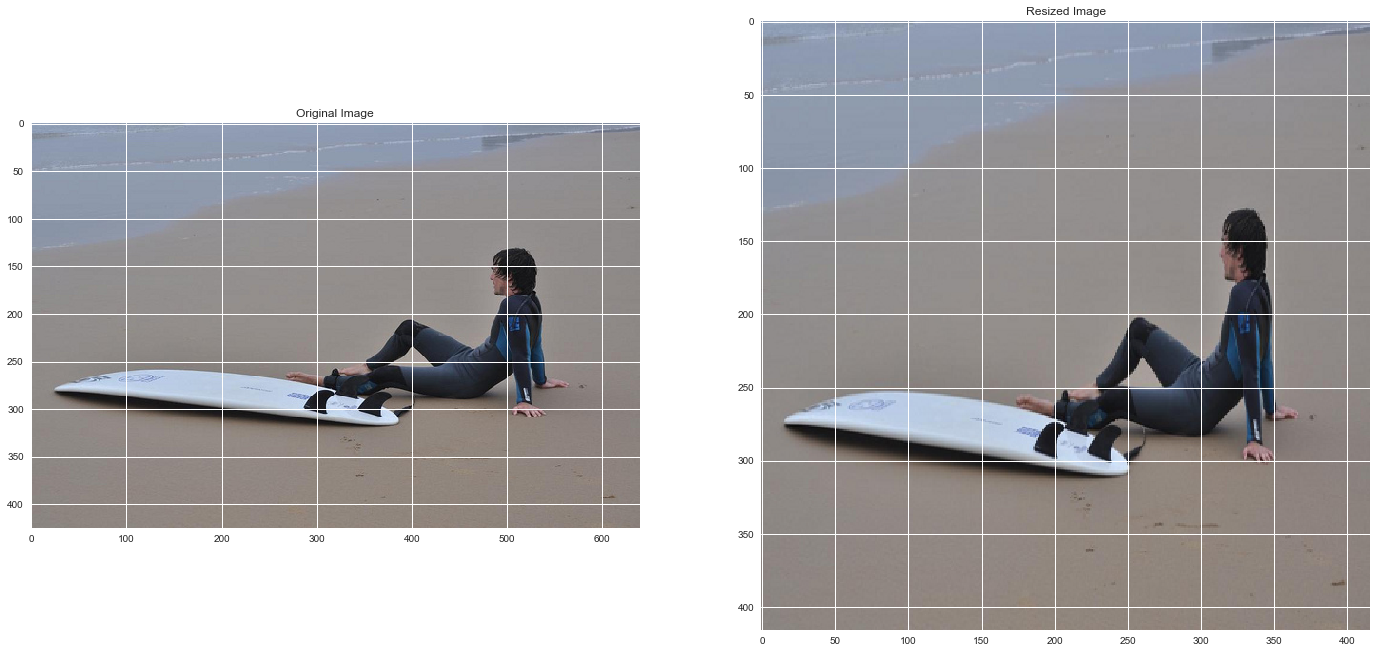

In [10]:
# Tamanho da figura
plt.rcParams['figure.figsize'] = [24.0, 14.0]

# Carregando imagem para classificar
img = cv2.imread('./imagens/surf.jpg')

# Convertendo para o espaço de cores RGB
original_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Redimensionando imagem para ser compatível com a primeira camada da rede neural  
resized_image = cv2.resize(original_image, (m.width, m.height))

# Exibição das imagens
plt.subplot(121)
plt.title('Original Image')
plt.imshow(original_image)
plt.subplot(122)
plt.title('Resized Image')
plt.imshow(resized_image)
plt.show()

In [11]:
# Patamar de NMS (Non-Maximum Supression)
# Ajuste de sensibilidade de imagens com baixa luminosidade
nms_thresh = 0.6

# Patamar do IOU (Intersect of Union), indicador se o retângulo 
# de identificação de imagem foi adequadamente desenhado
iou_thresh = 0.4



It took 1.744 seconds to detect the objects in the image.

Number of Objects Detected: 2 

Objects Found and Confidence Level:

1. person: 1.000000
2. surfboard: 0.994814


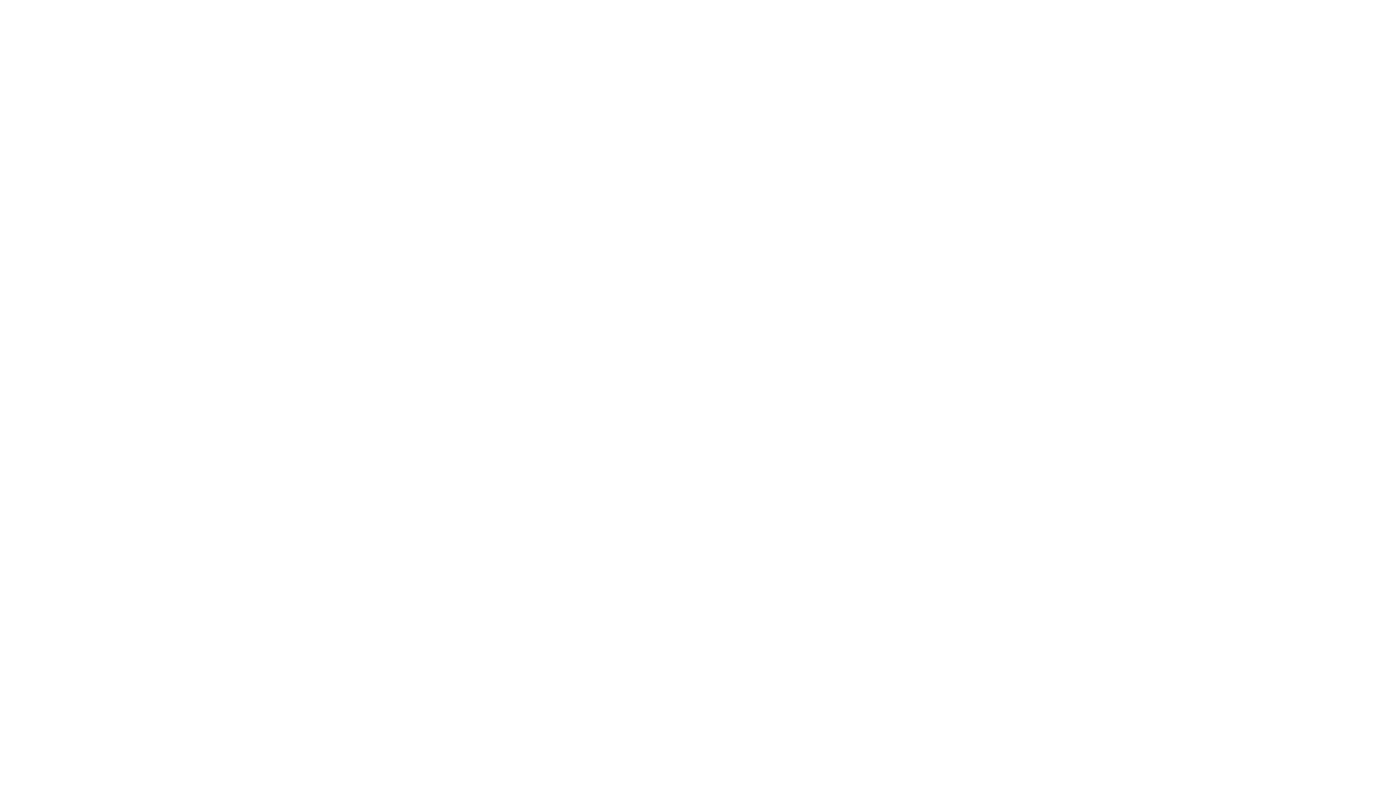

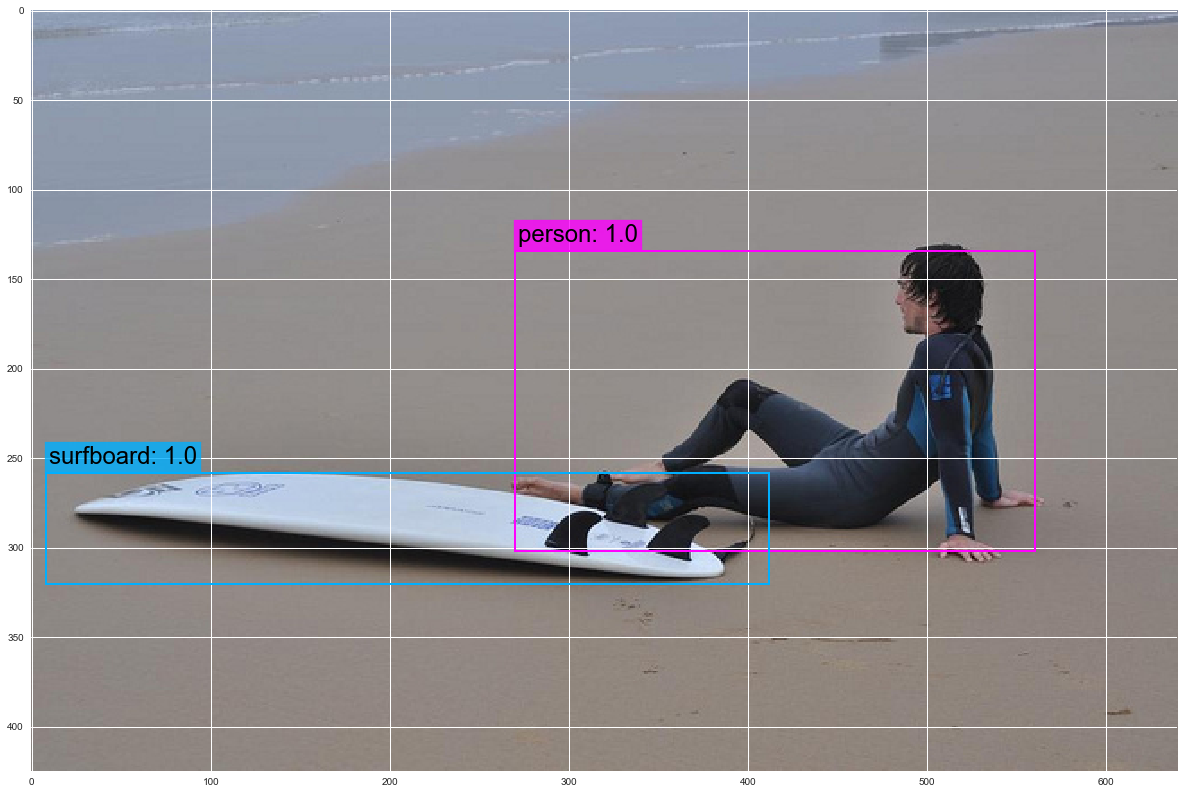

In [12]:
# Definindo tamnaho do gráfico
plt.rcParams['figure.figsize'] = [24.0, 14.0]

# Carregar imagem para classificação
img = cv2.imread('imagens/surf.jpg')

# Conversão para o espaço RGB
original_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Redimensionamento para adatapção da primeira camada da rede neural 
resized_image = cv2.resize(original_image, (m.width, m.height))

# Deteteção de objetos na imagem
boxes = detect_objects(m, resized_image, iou_thresh, nms_thresh)

# Objetos encontrados e nível de confiança
print_objects(boxes, class_names)

# Desenho no gráfico com os regângulos e rótulos
plot_boxes(original_image, boxes, class_names, plot_labels = True)